### Mockup for output transformation pipelines from the Data Readiness for AI Toolkit

In [1]:
from lale.expressions import it, sum, max, count, replace
import numpy as np
from lale.lib.lale import Scan, Join, Project, GroupBy, Aggregate, ConcatFeatures, Map, OutlierRemover, OutlierRemoverHO
from sklearn.feature_selection import SelectKBest as SelectFeatures
from lale.lib.lale import IdentityWrapper as Relational #hack!!
from lale.lib.autoai_libs import NumpyColumnSelector, CatEncoder, OptStandardScaler, FS1
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNN
from xgboost import XGBClassifier as XGBoost
import lale
lale.wrap_imported_operators()

Use Relational for `Map` and `Project` as we know they can be easily implemented as relational algebra.

In [2]:
preprocessing = Relational(op=Map(columns=[replace(it.gender, {'m':'male', 'f':'female'})]) >> Project(dropColumns=['salbegin']))

In [3]:
cats_prep = NumpyColumnSelector(columns=[0]) >> CatEncoder(dtype=np.float64)
cont_prep = NumpyColumnSelector(columns=[1,2]) >> OptStandardScaler(use_scaler_flag=True)

Outlier removal is tricky as it needs to be applied for "fit and transform" but not for "transform" when it is not called during fit of a pipeline. So not sure if the auto ai output pipeline should have OutlierRemover. 
It would look like this if it does. Please read towards the end for an option where outlier removal can be implemented as a higher order operator which behaves similar to imbalance correction.

In [4]:
all_prep = OutlierRemover(algorithm='isolation_forest') >> (cats_prep & cont_prep) >> ConcatFeatures >> FS1(additional_col_count_to_keep=3)

In [5]:
#Dropping outlier removal for now.
all_prep = (cats_prep & cont_prep) >> ConcatFeatures >> FS1(additional_col_count_to_keep=3)

In [6]:
classifier = LR | KNN | XGBoost

In [7]:
pipeline = preprocessing >> all_prep >> classifier

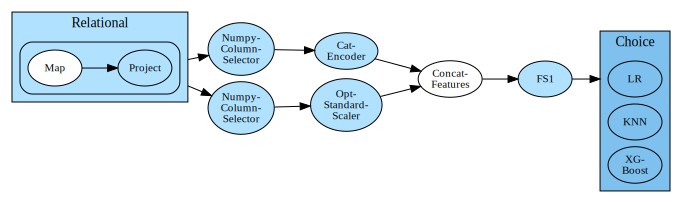

In [8]:
pipeline.visualize()

In [9]:
pipeline.pretty_print(show_imports=False, ipython_display=True)

```python
project = Project(dropColumns=['salbegin'])
numpy_column_selector_0 = NumpyColumnSelector(columns=[0])
cat_encoder = CatEncoder(dtype=np.float64)
numpy_column_selector_1 = NumpyColumnSelector(columns=[1, 2])
fs1 = FS1(additional_col_count_to_keep=3)
pipeline = Relational(op=Map(columns=[replace(it.gender, 
{'f': 'female', 'm': 'male'})]) >> project) >> ((numpy_column_selector_0 >> cat_encoder) & (numpy_column_selector_1 >> OptStandardScaler())) >> ConcatFeatures >> fs1 >> (LR | KNN | XGBoost)
```

Showing a case where outlier removal is implemented as a higher order operator. Please note that it can be applied anywhere during the pipeline, so if we believe the outlier detection works better after all the proprocessing, it can be applied only during classification. Or if we believe it needs to be applied to all the steps, that can be done too.

In [10]:
pipeline = preprocessing >> OutlierRemoverHO(operator = all_prep >> classifier)

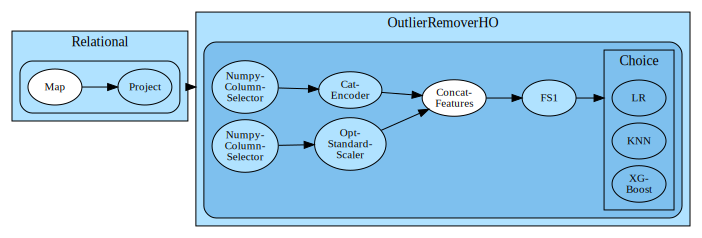

In [11]:
pipeline.visualize()